# Introduction
Linear Regression is the linear approach to modeling the relationship between a quantitative response ($y$) and one or more explanatory variables ($X$); also known as Response and Features, respectively.

This notebook focuses on the **potential modeling problems** that might arise due to the required assumptions for Linear Regression.

Let's load the data and necessary libraries. The toy dataset used in this example contain information on house prices and its characteristics, such as Neighborhood, square footage, # of bedrooms and bathrooms.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

%matplotlib inline

df = pd.read_csv("house_prices.csv")
df.drop(columns="house_id", inplace=True)
df.head(3)

,neighborhood,area,bedrooms,bathrooms,style,price
0,B,1188,3,2,ranch,598291
1,B,3512,5,3,victorian,1744259
2,B,1134,3,2,ranch,571669


Now let's fit the final model identified in the Part 1 of Linear Regression series:

In [2]:
# Creating dummy variable for Neighborhoods
df = df.join(pd.get_dummies(df.neighborhood, prefix="neighb"))

# Creating interaction term to be incorporated in the model
df["area_neighb"] = df.area * df.neighb_B

df["intercept"] = 1
features_list = ["intercept", "area", "neighb_B", "area_neighb"]

model = sm.OLS(df.price, df[features_list])
fitted_model = model.fit()
fitted_model.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Results: Ordinary least squares
========================================================================
Model:                 OLS               Adj. R-squared:      1.000     
Dependent Variable:    price             AIC:                 71986.6799
Date:                  2019-04-10 12:12  BIC:                 72013.4966
No. Observations:      6028              Log-Likelihood:      -35989.   
Df Model:              3                 F-statistic:         6.131e+10 
Df Residuals:          6024              Prob (F-statistic):  0.00      
R-squared:             1.000             Scale:               8986.8    
------------------------------------------------------------------------
              Coef.    Std.Err.      t      P>|t|    [0.025     0.975]  
------------------------------------------------------------------------
intercept   12198.0608   3.1492   3873.3747 0.0000 12191.8872 12204.2343
area          248.1610   0.0013 194094.9191 0.0000   248.1585   248.1635
neighb_B      132.5642   4.9709     26.6682 0.0000   122.8195   142.3089
area_neighb   245.0016   0.0020 121848.3887 0.0000   244.9976   245.0055
------------------------------------------------------------------------
Omnibus:               214.393         Durbin-Watson:            1.979  
Prob(Omnibus):         0.000           Jarque-Bera (JB):         398.418
Skew:                  -0.277          Prob(JB):                 0.000  
Kurtosis:              4.131           Condition No.:            12098  
========================================================================
* The condition number is large (1e+04). This might indicate
strong multicollinearity or other numerical problems.
"""

# Potential Modeling Problems
Depending on the main objective of your model (prediction, inference, most important features), you might need to address some specific problems - but not necessarily all of them.

These are the potential problems related to [Multiple Linear Regression assumptions](http://people.duke.edu/~rnau/testing.htm): some should be checked when choosing the predictors for the model; others only after the model has been fitted - while some should be checked in both situations.

## 1. Outliers & Leverage Points
Outliers and leverage points lie far away from the regular trends of the data. These points can have a large influence on the fitted model and the required assumptions, such as linearity and normality of errors. Therefore, this should be the very first step to check when fitting a model. 

+ **Outliers**: extreme values on the y axis, do not follow the trend
+ **Leverage Points**: follows the trend, but extreme values on the x axis

Most of the time, these points are resulted by typos (data entry), malfunctioning sensors (bad data collected), or even just extremely rare events. 
>$\implies$ These cases can be removed from the dataset or inputed using k-nearest neighbors, mean, or median.

Other times, these are actually correct and true data points (known as **Natural Outliers**), not necessarily measurement or data entry errors. 

This situation would **not** call for removal, instead it requires further exploration to better understand the data. For example, fraud detection goal is exactly identifying extreme out-of-pattern transactions. 
>$\implies$ 'Fixing' is more subjective. If there is a large number of outliers, it is advised to create separate models.

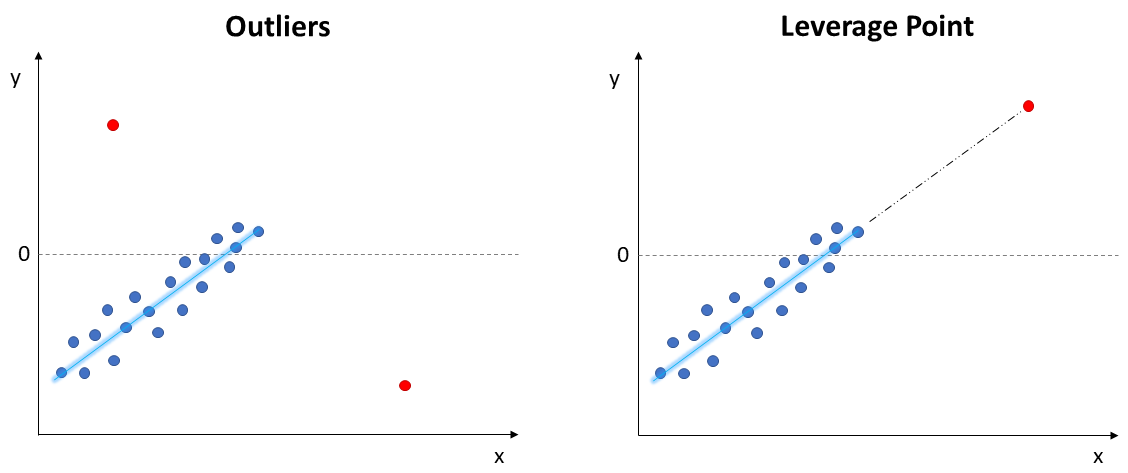

Some typical methods for Outlier Detection:

+ **Tukey's Fence**
+ **Standardized Residuals**
+ **Outliers Removal Strategy**
+ **Unsupervised Outlier Detection**:
    - *Isolation Forest*
    - *Local Outlier Factor*
+ **Deleted Residuals**:
    - *Difference in FITS*
    - *Cook's Distance*

### 1.1) Tukey's Fence
Applied on predictors individually. Typically represented in a Box-Plot, values more extreme than the lower and upper boundaries of Tukey's fence are considered outliers and should be further investigated:
1. Calculate the first and third quartiles, $Q_1$ and $Q_3$
2. Calculate the Inter-Quartile Range, $IQR = Q_3 - Q_1$
3. Remove values more extreme than upper and lower boundaries:
    - **Upper**: $Q_3 + 1.5 \times IQR$
    - **Lower**: $Q_1 - 1.5 \times IQR$
    
>**Note**: it is important to note this method is commonly used, but only captures extreme values for univariate distribution. It is important to investigate multivariate distribution as well.

In [3]:
def outlier_Tukeys_Fence(df, variable, factor=1.5, drop_outliers=False):
    """
    Input: dataframe (df) and variable name (string)
    Output: Upper and Lower Tukey's Fence and Plot
    --> If 'drop_outliers' True, automatically remove identified data points
    """

    Q3 = df[variable].quantile(0.75)
    Q1 = df[variable].quantile(0.25)
    IQR = Q3 - Q1

    upper = Q3 + factor * IQR
    lower = Q1 - factor * IQR
    print(f"Boundaries: [{lower:,} | {upper:,}]\n")

    # Filtering Outliers
    upper_outliers = df.query(f"{variable} > @upper")
    lower_outliers = df.query(f"{variable} < @lower")

    print(f"Points outside Upper Fence: {len(upper_outliers)}")
    print(f"Points outside Lower Fence: {len(lower_outliers)}")

    # Plotting
    df[variable].plot(style="+", label="_NA")
    upper_outliers[variable].plot(style="ro", mfc="none", label="outliers")

    try:
        lower_outliers[variable].plot(style="ro", mfc="none")
    except:
        pass

    plt.title("Outliers: Tukey's Fence")
    plt.xlabel("index")
    plt.ylabel(f"{variable}")
    plt.legend()

    if drop_outliers:
        df.drop(upper_outliers.index, inplace=True)
        df.drop(lower_outliers.index, inplace=True)
        df.reset_index(drop=True)

In [4]:
df2 = df.copy()
len(df2)

6028

Boundaries: [-1,631.0 | 5,985.0]

Points outside Upper Fence: 26
Points outside Lower Fence: 0


6002

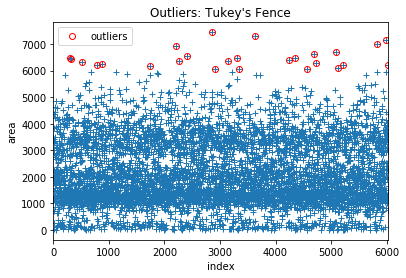

In [5]:
outlier_Tukeys_Fence(df2, "area", drop_outliers=True)
len(df2)

### 1.2) Standardized Residuals
Applied on the final model. A slight twist on the typical plot of Residuals by Fitted values. This method uses the standardized residual instead - which is obtained by dividing the error by the standard deviation of errors, $\frac{e}{std(e)}$
+ **Outliers**: Values more extreme than $\pm$ **3 standard deviation**, since they represent **99.7%** of data.

In [6]:
def outliers_Standard_Error(df, fitted_model=fitted_model):
    """
    Assumption: model has already been fitted
    Input: dataframe
    Output: plot of Standard Residuals by Fitted Values
    --> values outside 3 std are likely outliers
    --> red line represent smoothed error variance regression
    Ex: flat horizontal line along 0 .:. Homoscedastic
    """
    # Standardized Error: absolute values > 3 means more extreme than 99.7%
    df["error"] = fitted_model.resid
    df["fitted_value"] = fitted_model.fittedvalues

    df["standard_error"] = df.error / np.std(df.error)
    upper = df.query("standard_error > 3")
    lower = df.query("standard_error < -3")
    print(f"Points > 3 Std: {len(upper)}")
    print(f"Points < -3 Std: {len(lower)}")
    print(f"Total of possible outliers: {len(upper) + len(lower)}")

    sns.regplot(
        df.fitted_value,
        df.standard_error,
        lowess=True,
        scatter_kws={"alpha": 0.5},
        line_kws={"color": "r"},
        label="_NA",
    )

    plt.scatter(
        data=upper,
        x="fitted_value",
        y="standard_error",
        color="r",
        facecolor="none",
        label=None,
    )
    plt.scatter(
        data=lower,
        x="fitted_value",
        y="standard_error",
        color="r",
        facecolor="none",
        label="Possible Outliers",
    )

    plt.axhline(0, color="gray", ls=":")
    plt.axhline(3, color="r", ls=":")
    plt.axhline(-3, color="r", ls=":")
    plt.legend()
    plt.title("Scale-Location: Error Variance");

Points > 3 Std: 24
Points < -3 Std: 28
Total of possible outliers: 52


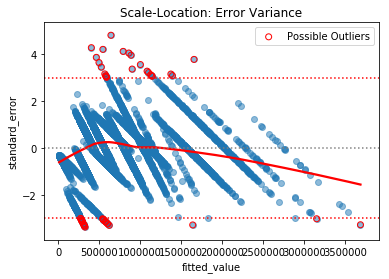

In [7]:
outliers_Standard_Error(df)

### 1.3) Outliers Removal Strategy
This more generalized strategy can be implemented in any model and repeated multiple times, until the best model fit is found:

1. Train the model over all data points from the Train dataset
2. Remove 10% points with largest residual error
3. Re-train the model and evaluate against the Test dataset
4. Repeat from step 2, until best model fit is found

### 1.4) Unsupervised Outlier Detection
Two of the most used unsupervised methods are [Isolation Forest & Local Outlier Factor](https://scikit-learn.org/stable/auto_examples/plot_anomaly_comparison.html#sphx-glr-auto-examples-plot-anomaly-comparison-py). *See linked documentation for detailed explanation*.

The downside of such advanced multivariate methods (random tree and density based) is the requirement to arbitrarily specify the **contamination factor** - that is, the percentage of dataset believed to be "bad".

It should be implemented iteratively using the **Outliers Removal Strategy** (evaluating model performance against a test set).

Isolation Forest | Outliers detected = 602
Local Outlier Factor | Outliers detected = 603


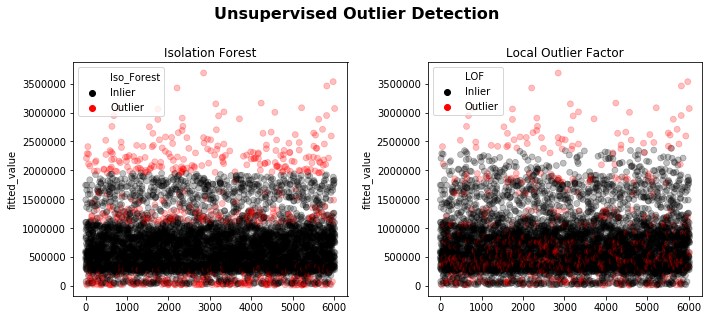

In [8]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

# percentage of dataset 'contaminated' with outliers
contamination_factor = 0.1

algorithm_list = [
    (
        "Isolation Forest",
        IsolationForest(
            behaviour="new", contamination=contamination_factor, random_state=42
        ),
        "Iso_Forest",
    ),
    (
        "Local Outlier Factor",
        LocalOutlierFactor(n_neighbors=35, contamination=contamination_factor),
        "LOF",
    ),
]

# X = df[features_list]
X = df[["price", "area", "neighb_B", "area_neighb"]]
counter = 0

fig, ax = plt.subplots(1, 2, figsize=(10, 4))

for name, model, tag in algorithm_list:
    # Apply unsupervised method and store classification: 1 = Inliner; -1 or 0 = Outlier
    df[f"{tag}"] = model.fit_predict(X)

    # Rename for legend purpose
    df[f"{tag}"] = np.where(df[f"{tag}"] == 1, "Inlier", "Outlier")

    sns.scatterplot(
        df.index,
        df.fitted_value,
        hue=df[f"{tag}"],
        alpha=0.25,
        palette=["k", "r"],
        ax=ax[counter],
        edgecolor=None,
    )

    ax[counter].set_title(f"{name}")

    # Amount of Outliers (dataset size * contamination_factor)
    outliers = len(df.query(f'{tag} == "Outlier"'))
    print(f"{name} | Outliers detected = {outliers:,}")

    counter += 1

plt.tight_layout()
fig.suptitle("Unsupervised Outlier Detection", size=16, weight="bold", y=1.1);

### 1.5) [Deleted Residuals](https://newonlinecourses.science.psu.edu/stat501/node/340/)
The previous methods can be biased, since the model has been fitted using the entire dataset (extreme values included - if any). The alternative is a systematic approach of withholding one observation, fitting the model and calculating a specific metric - repeating the process for the entire data set. 

The interpretation follow each metric specific "guideline":
+ **Difference in Fits (DFFITS)**: values that stick out from the others are potentially influential extreme data points
+ **Cook's Distance**:
    - $d > 0.5$: might be influential points. Further investigate
    - $d > 1$: data point likely to be influential

>**Influential**: data points extreme enough to significantly impact the fitted model results, such as coefficients, p-value, and Confidence Intervals.

### 1.5.1) Difference in Fits (DFFITS)
Values that stick out from the others are potentially influential extreme data points:

In [9]:
def outliers_DFFITS(df, fitted_model=fitted_model):
    """
    Assumption: model has already been fitted
    Input: dataframe
    Output: plot with Difference in FITS
    --> Values that stick out from the rest should be investigated
    """
    # DFFITS
    df["dffits"] = fitted_model.get_influence().dffits[0]

    # Plotting
    df.dffits.plot(style="o", alpha=0.5)
    df.query("dffits == @df.dffits.max()").dffits.plot(
        style="ro", mfc="none", label="Max"
    )
    df.query("dffits == @df.dffits.min()").dffits.plot(
        style="ro", mfc="none", label="Min"
    )

    plt.title("Deleted Residuals: Difference in FITS")
    plt.xlabel("index")
    plt.ylabel("DFFITS");

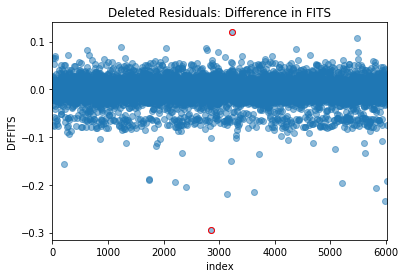

In [10]:
outliers_DFFITS(df)

In this example, there are no points sticking out significantly more than the others, suggesting there are no influential extreme data points.

### 1.5.2) Cook's Distance
+ $d > 0.5$: might be influential points. Further investigate
+ $d > 1.0$: data point likely to be influential

In [11]:
def outliers_Cooks_Distance(df, fitted_model=fitted_model):
    """
    Assumption: a model has already been fitted (statsmodels)
    Input: data frame and fitted model
    Output: plot of Cook's Distance, highlighting likely influential points
    --> d > 0.5: possible influential. Further investigate
    --> d > 1: likely influential
    """
    df["cooks_distance"] = fitted_model.get_influence().cooks_distance[0]

    # Plotting
    df.cooks_distance.plot(style="o", alpha=0.5, label="Not Influential")
    try:
        df.query("cooks_distance > 0.5").cooks_distance.plot(
            style="r", mfc="none", label="Possible Influential"
        )
        plt.axhline(0.5, color="r", ls=":")

        df.query("cooks_distance > 1").cooks_distance.plot(
            style="r", label="Influential"
        )
        plt.axhline(1, color="darkred", ls="--")
    except:
        pass

    plt.legend()
    plt.title("Deleted Residuals: Cook's Distance")
    plt.xlabel("index")
    plt.ylabel("Cook's Distance");

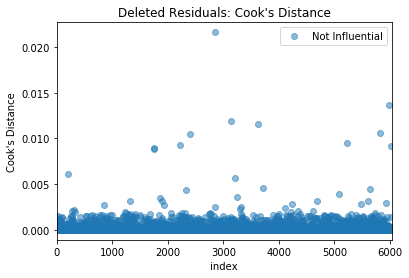

In [12]:
outliers_Cooks_Distance(df)

In this example, there are no points with **Cook's distance** greater than 0.5, suggesting there are no influential extreme data points.

## 2. Multicollinearity
One of the major 4 assumptions of Linear Regression, it assumes the (linear) **independence** between predictors. That is, it is not possible to infer one predictor based on the others.

Ultimately, we want the explanatory variables (predictors) to be correlated to the response, not between each other.

In the case of correlated features being used simultaneously as predictors, the model can yield:
+ Inverted coefficient sign from what we would expect
+ Unreliable p-value for the Hypothesis Test of variable coefficient being significantly $\neq$ 0

To investigate and identify multicollinearity between explanatory variables, we can use two approaches:
+ **Visual** 
+ **Metric**:
    - **Correlation Coefficient**, $R$
    - **Variance Inflation Factor (VIF)**
    
>**Hint**: Multicollinearity should be checked while choosing predictors: the modeling goal is to <u>identify relevant features</u> to the response, that are <u>independent from each other</u>.

### 2.1) Bivariate Plot (between Predictors)
Scatter plot between two variables looking for any relationship (positive or negative):

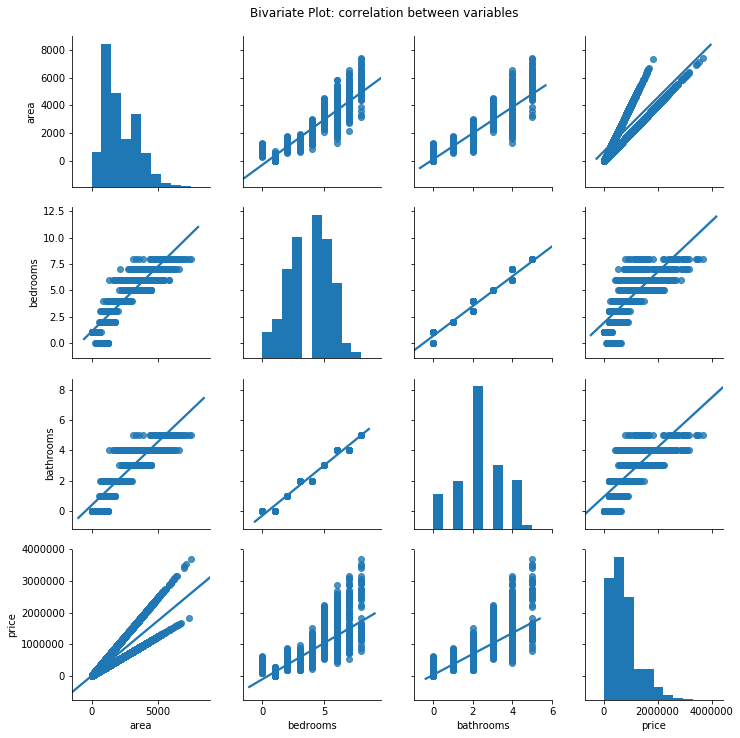

In [13]:
# Visually investigating relationship between features
chart = sns.pairplot(data=df[["area", "bedrooms", "bathrooms", "price"]], kind="reg")

chart.fig.suptitle("Bivariate Plot: correlation between variables", y=1.02);

It is possible to see the quantitative variables are correlated to each other, having a positive linear relationship.

### 2.2) Pearson's Correlation Matrix (Heatmap)

In [14]:
def Correlation_Heatmap(df, variables_list=None, figsize=(10, 8)):
    """
    Input: dataframe; optional list of variables
    Output: Pearson correlation matrix heatmap, plotting only the lower diagonal
    """
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt

    # Compute the correlation matrix of the dataset
    if variables_list:
        corr = df[variables_list].corr()
    else:
        corr = df.corr()

    # Generate mask to hide the upper triangle/diagonal
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    # plotting
    fig, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(10, 220, as_cmap=True)

    # Draw heatmap with mask
    sns.heatmap(
        corr,
        mask=mask,
        cmap=cmap,
        vmin=-1,
        vmax=1,
        center=0,
        square=True,
        annot=np.where(abs(corr) > 0.1, corr, 0),
        linewidths=0.5,
        cbar_kws={"shrink": 0.75},
    )

    plt.title("Pearson Correlation Matrix Heatmap");

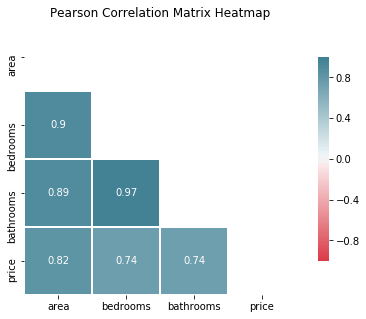

In [15]:
Correlation_Heatmap(df, ["area", "bedrooms", "bathrooms", "price"], figsize=(8, 5))

According to the Pearson Correlation coefficient, the variable **area** is strongly correlated to **bedrooms** (0.9) and **bathrooms** (0.89), meaning we should use only 1 of these variables in the model.

The response **price** is strongly positively correlated to all quantitative variables, with **area** (0.82) stronger than **bedrooms** and **bathrooms** (0.74). 

$\implies$ Which suggests we should choose **area** as our predictor.

### 2.3) Variance Inflation Factor (VIF)
The general rule of thumb is that VIFs exceeding 4 warrants further investigation, while VIFs exceeding 10 indicates serious multicollinearity, requiring correction:

In [16]:
# Metric investigation of correlation: VIF
def VIF(df="df", model_formula="y ~ x1 + x2 + x3"):
    """
    Calculates the Variance Inflation Factor of a given model (written in R-like form).
    Input: dataframe containing the data, and 'R'-like formula for linear model
    Output: dataframe "vif" containing the name and VIF for each predictor
    --> VIF > 10 suggests strong correlation between features. Remove one at a time and re-evaluate.
    --> VIF > 4 warrant further investigation for Multi-collinearity.
    """
    # importing necessary modules
    from pandas import DataFrame
    from patsy import dmatrices
    from statsmodels.stats.outliers_influence import variance_inflation_factor

    y, X = dmatrices(model_formula, df, return_type="dataframe")
    vif = DataFrame()
    vif["VIF"] = [
        variance_inflation_factor(X.values, i) for i in range(X.shape[1])
    ]  # over all columns
    vif["feature"] = X.columns
    return vif

In [17]:
model_formula = "price ~ area + bedrooms + bathrooms"
VIF(df, model_formula)

,VIF,feature
0,7.327102,Intercept
1,5.458190,area
2,20.854484,bedrooms
3,19.006851,bathrooms


Looks like there is a serious sign of multicollinearity between the explanatory variables. Let's remove the highest one, **bedrooms** and recalculate the VIF:

In [18]:
# Removing correlated features: bedrooms
model_formula = "price ~ area + bathrooms"
VIF(df, model_formula)

,VIF,feature
0,4.438137,Intercept
1,4.871816,area
2,4.871816,bathrooms


Removing **bedrooms** has improved the multicollinearity condition, but we still have **bathrooms** with a value greater than 4 - which warrants further investigation.

Since our previous analysis using the Pearson correlation coefficient showed **bathroom** to be strongly correlated to **area**, let's remove it and calculate the VIF one more time:

In [19]:
# Removing correlated features
model_formula = "price ~ area"
VIF(df, model_formula)

,VIF,feature
0,3.98224,Intercept
1,1.00000,area


As expected, since we are only using one explanatory variable, the VIF reaches it's lowest possible value of 1. In this case, amongst all quantitative variables, we should regress our model using only the **area**.

## 3. Linearity
The main assumption of Linear Regression, there should be a linear relationship that truly exists between the response $y$ and the predictor variables $X$. If this isn't the case, the predictions will not be accurate and the interpretation of coefficients won't be useful.

We can verify if a linear relationship is reasonable by analyzing two plots:
+ **Pair Plot**
+ **Residual Plot**

>*Residuals* can be understood as the model error.<br>
<u>Ideally</u>, the error would be randomly scattered around 0, as seen in the <u>left-most case</u> in the image below.

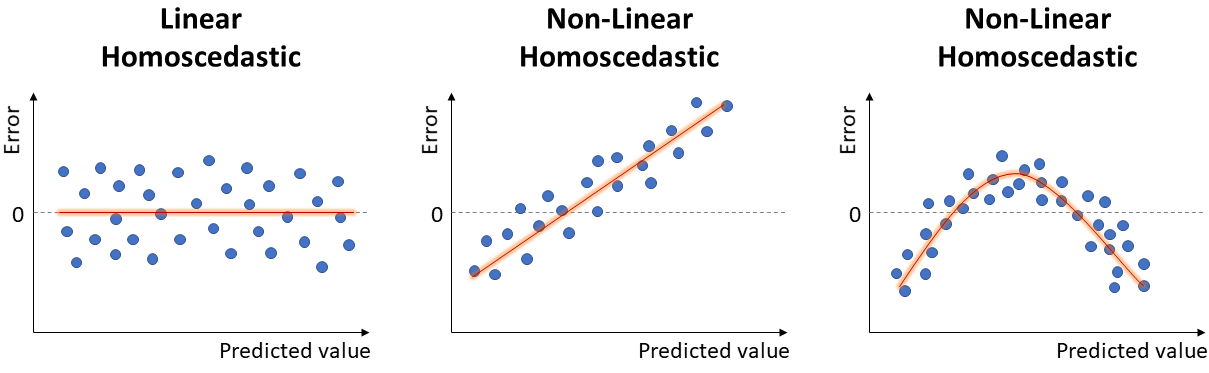

### 3.1) Pair Plot (Response vs Predictor)
Bivariate plot between the response and each individual predictor. There should be some kind of linear relationship, either positive or negative.

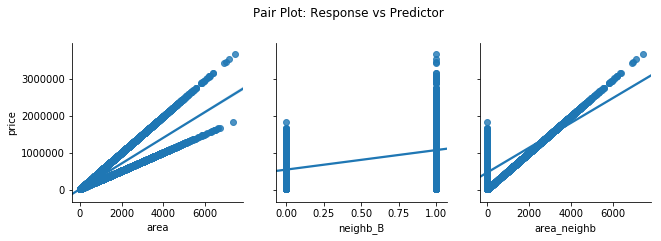

In [20]:
# Pairplot of y vs. X
chart = sns.pairplot(
    df, x_vars=["area", "neighb_B", "area_neighb"], y_vars="price", kind="reg", height=3
)
chart.fig.suptitle("Pair Plot: Response vs Predictor", y=1.1);

### 3.2) Residual Plot
Plot of **residuals**, $(y-\hat y)$ by the predicted values, $\hat y$. Should be randomly scattered around 0. 

If there is any kind of structure/pattern, it suggests there is some other relationship between the response and the predictors, violating the Linearity assumption and compromising the model.

In [21]:
def residual_plot(df, fitted_model=fitted_model):
    """
    Assumption: a model has already been fitted (statsmodels)
    Input: dataframe and fitted model
    Output: plot of Residuals by Fitted Values
    --> Linearity: residuals should be randomly scattered around 0 (flat horizontal line)
    --> Non-Linearity: there is a structure in the residuals
    """
    df["error"] = fitted_model.resid
    df["fitted_value"] = fitted_model.fittedvalues

    sns.regplot(
        y=df.error,
        x=df.fitted_value,
        lowess=False,
        line_kws={"color": "red"},
        scatter_kws={"alpha": 0.5},
    )
    plt.axhline(0, color="gray", ls=":")
    plt.title("Residual Plot");

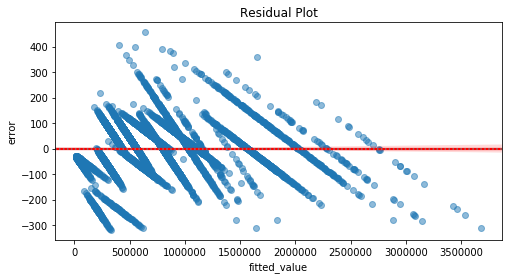

In [22]:
plt.figure(figsize=(8, 4))
residual_plot(df, fitted_model)

The residuals are not randomly scattered around 0. Indeed, there is some kind of pattern/structure. Hence, it violates the Linearity assumption, compromising the model.

One could make use of **data transformation** ([predictor](https://newonlinecourses.science.psu.edu/stat501/node/319/), [response](https://newonlinecourses.science.psu.edu/stat501/node/320/), or [both](https://newonlinecourses.science.psu.edu/stat501/node/321/)) or add new predictors (higher order, interaction term) in order to satisfy the Linearity assumption:

+ **Natural Log transformation**: only for positive values, spread out small values and bring large values closer. Appropriate for skewed distribution.

+ **Reciprocal transformation**: applied on non-zero variable, appropriate for highly skewed data, approximating it to a normal distribution

+ **Square Root**: only for positive values, appropriate for slightly skewed data.

+ **Higher Order**: applied for negative values, appropriate for highly left-skewed distribution.

+ **[Box-Cox technique](https://www.statisticshowto.datasciencecentral.com/box-cox-transformation/)**: this technique allows to systematically test the best parameter $\lambda$ in the power transformation. Ultimately, it identifies the best type of transformation to be applied in order to approximate the variable to a normal distribution.

$$y(\lambda) = \begin{cases}
  \frac{y^{\lambda} - 1}{\lambda},\space \text{if $\lambda \neq 0$}\\
  ln(y), \space \text{if $\lambda = 0$}
\end{cases}$$

> **Hint**: when dealing with negative values, add a constant to the variable in order to transform it into positive values before using Box-Cox technique.

It is important to highlight that, after transforming a variable, it is necessary to "transform it back" when calculating Confidence Intervals, and the interpretation of coefficients might change from additive ($y$ units change per 1 $X_i$ unit increase) to multiplicative ($y$ % change due to 1% $X_i$ increase).

As a matter of fact, you should not move forward to verify other assumptions before making sure Linearity holds. Otherwise, the model will not yield useful results and will be limited to the scope of data in which it was trained - no extrapolation.

>**Attention**: this notebook focuses on the **Potential Modeling Problems**. Fixing the Linearity issue is not trivial and we will not address it at this time.

## 4. Correlated Residuals
It frequently occurs if the data is collected over time (stock market) or over a spatial area (flood, traffic jam, car accidents).

The main problem here is failing to account for correlated errors since it allows to improve the model performance by incorporating information from past data points (time) or the points nearby (space).

In case of **serial correlation**, we can implement [ARMA or ARIMA](http://www.statsref.com/HTML/index.html?arima.html) models to leverage correlated errors to make better predictions.

We can check for autocorrelation using two methods:
+ **Durbin-Watson Test**
+ **Residual vs. Order Plot**
+ **Autocorrelation Plot**

### 4.1) Durbin-Watson Test
We can verify if there are correlated errors by interpreting the [Durbin-Watson test](https://en.wikipedia.org/wiki/Durbin%E2%80%93Watson_statistic) - which is available in the `statsmodels` result summary:
+ verifies if there is serial correlation between one data point ($t$) and its previous ($t$-1) - called **lag** - over all residuals ($res.^t$, $res.^{t-1}$)
+ Test statistic varies between [1 - 4]
+ **Test = 2 $\pm$ 0.6**: no correlated errors
+ **Test < 1.4**: positive correlation between errors 
+ **Test > 2.6**: negative correlation between errors

>$\implies$ In our example, the *Durbin-Watson* test value of **1.979** is quite close to **2**, suggesting there are <u>no auto-correlated errors</u>.

### 4.2) Residual vs. Order Plot
If the **order**/**sequence** in which the data were collected is known, it is possible to visually assess the plot of Residuals vs. Order (of data collection). 

+ **No Correlation**: residuals are randomly scattered around 0.
+ **Time Trend**: residuals tend to form a positive linear pattern (like a diagonal). One should incorporate "time" as a predictor - and move to the realm of Time Series Analysis.
+ **Positive Correlation**: residuals tend to be followed by an error of the same sign and about the same magnitude, clearly forming a sequential pattern of smoothed ups and downs (like a sine curve). Once again, in this case one should move to Time Series.
+ **Negative Correlation**: residuals of one sign tend to be followed by residuals of the opposite sign, forming a sharp zig-zag line (like a W shape). Just as well, move to Time Series Analysis.

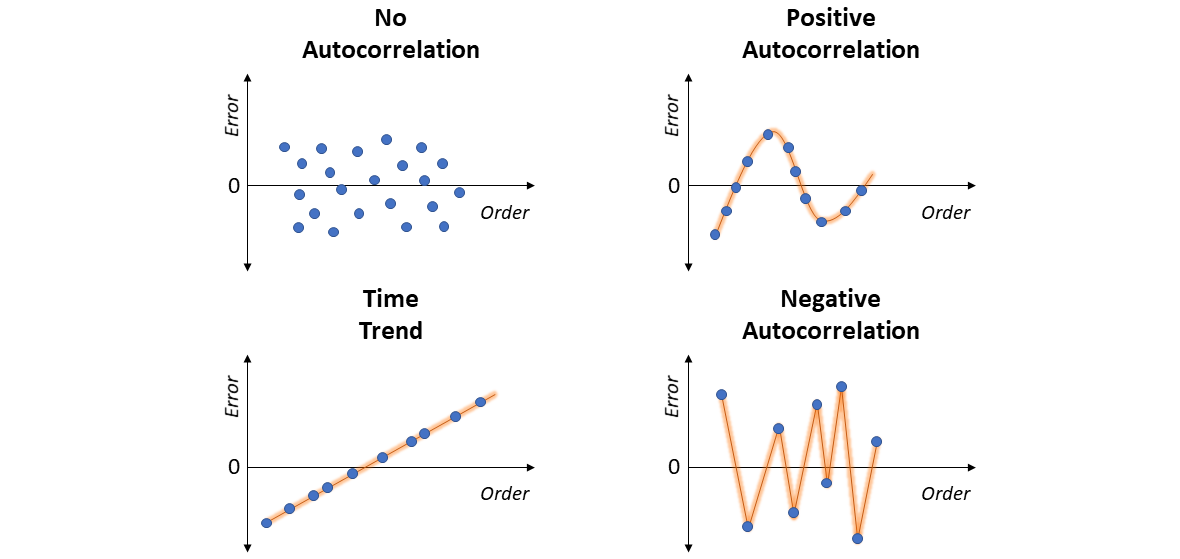

### 4.3) Autocorrelation Plot
If most of residual autocorrelation falls within the 95% Confidence Interval band around 0, no serial correlation.

`from statsmodels.graphics.tsaplots import plot_acf`

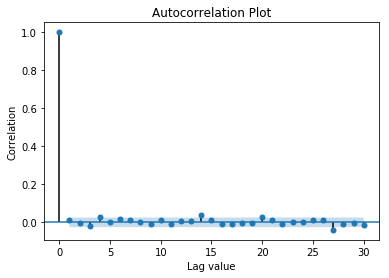

In [23]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df.error, lags=30, title="Autocorrelation Plot")
plt.xlabel("Lag value")
plt.ylabel("Correlation");

In this example, the data is not autocorrelated.

## 5. Normality of Residuals
Another assumption of Linear Regression, the residuals should be normally distributed around 0. This is important for achieving reliable **Confidence Intervals**.

>This particular problem doesn't significantly impact the prediction accuracy. But it leads to wrong p-values and confidence intervals when checking if coefficients are significantly different than 0. This <u>compromises the model inference capability</u>.

We can verify if normality of residuals is reasonable by analyzing it visually or using statistical tests:
+ **Visually**: 
    - **Histogram**
    - **Probability Plot**
    
Another possibility is that there are two or more subsets of the data having peculiar statistical properties, in which case separate models should be built.

It is also important to highlight this assumption might be violated due to the violation of Linearity - which would call for **transformation**. 

You would transform the response, individual predictors, or both, until the **Normality of Residuals** is satisfied. Note the variables *per se* don't need to be normally distributed: the focus here is on the distribution of **Residuals**.

>**Note**: Afterwards, it is necessary to go back and check if Linearity with the new transformations still holds true.

In some cases, the problem with the error distribution is mainly due to few very large errors (influential data points). Such data points should be further investigated and appropriately addressed, as covered in the **Outliers** and **Leverage Point** section.

### 5.1) Histogram of Residuals
Visually check if the data is normally distributed (bell shape), skewed, or bi-modal:

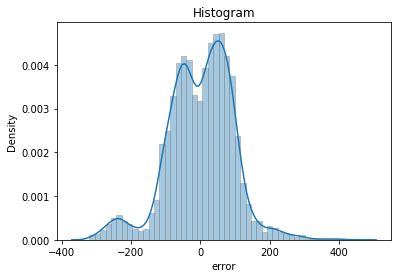

In [24]:
sns.distplot(df.error, hist_kws={"edgecolor": "gray"})
plt.ylabel("Density")
plt.title("Histogram");

The histogram does not present the well-behaved Bell shape. Hence, this is not a normal distribution. More like bimodal.

### 5.2) Probability Plot of Residuals
Also known as QQ plot, this approach is better for small sample size.
Different than Histogram, this plot allows to clearly identify values far from the Normal.

Ideally, the points will fall over the diagonal line.

The image below illustrate some of the typical trends of a Probability Plot under specific situations: Normal, Bimodal, Light Tail, Heavy Tail, Left Skew, and Right Skew:

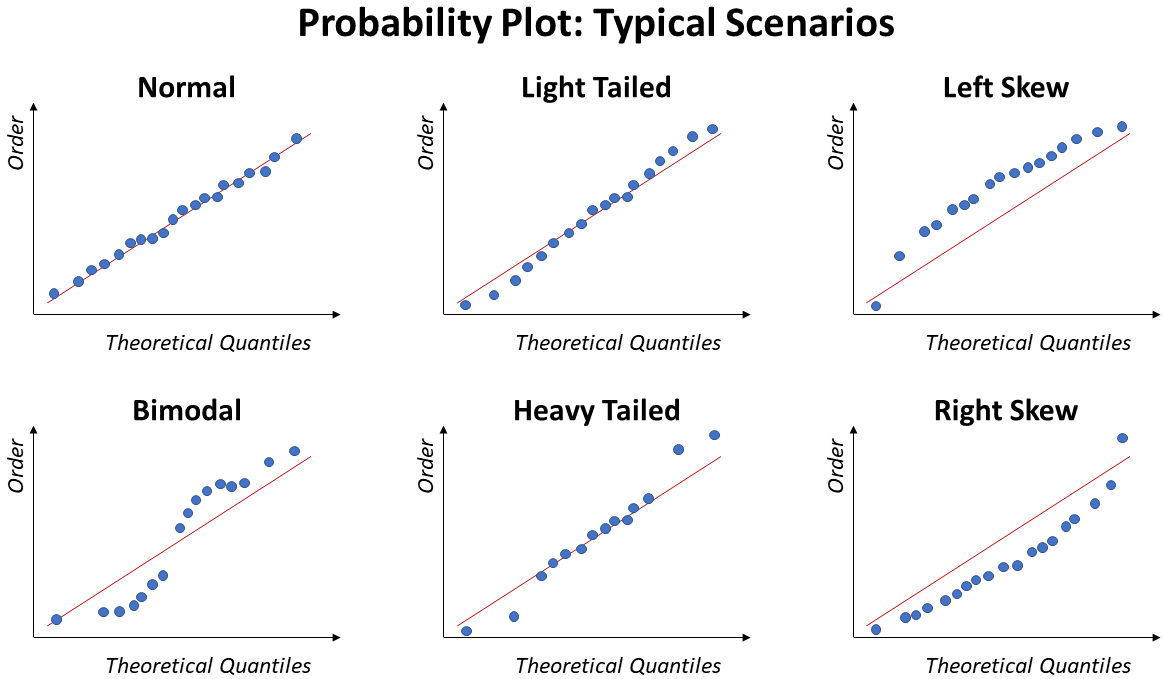

In [25]:
def ProbPlot(df, fitted_model, ax=None):
    """
    Assumption: a model has already been fitted (statsmodels)
    Input: dataframe to be analyzed
    Output: Prob Plot of Residuals. Ideally, perfect diagonal.
    """
    # importing required modules
    from matplotlib.pyplot import subplots
    from scipy.stats import probplot

    df["error"] = fitted_model.resid

    if ax:
        chart = probplot(df.error, plot=ax)
    else:
        fig, ax = subplots()
        chart = probplot(df.error, plot=ax)

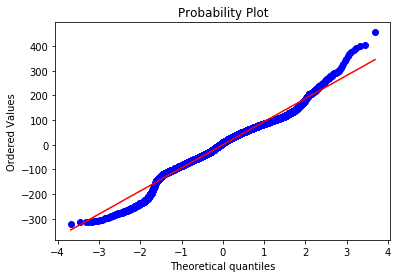

In [26]:
ProbPlot(df, fitted_model);

The points do not follow the diagonal line. As a matter of fact, it is possible to make out an stretched **"S" form** with gaps on the both extremities, suggesting the distribution to be **bimodal**. 

Which seems reasonable when looking at the previous histogram plot.

### 5.3) Statistical Tests
Some methods testing the Null Hypotheses of data being Normal. If low p-value, suggests data does not likely come from a normal distribution.
+ **Shapiro-Wilk**: `from scipy.stats import shapiro`
+ **D'Agostino**: `from scipy.stats import normaltest`
+ **Jarque-Bera**: `from scipy.stats import jarque_bera`. Recommended only for datasets larger than 2,000 observations. *Already included in `statmodels` result summary.*
    
>**Note**: Statistical tests are <u>not recommended</u> for datasets <u>larger than 5,000 observations</u>.

In [27]:
def Normality_Tests(variable, alpha=0.05):
    """
    Input: residual variable to be tested for Normal Distribution ('df.error') and significance level, alpha
    Output: print the test statistics and p-value for Shapiro-Wilk, D\'Agostino, and Jarque-Bera Test'
    --> if p-value < alpha, Reject the Null, suggesting NOT normal distribution
    """
    from scipy.stats import shapiro, normaltest, jarque_bera

    normality_tests = {
        "Shapiro-Wilk": shapiro,
        "D'Agostino": normaltest,
        "Jarque-Bera": jarque_bera,
    }

    for name, test in normality_tests.items():
        stat, p = test(variable)
        print(f"{name} Test: {stat:.3f} | p-value: {p:.3f}")
        if "Bera" in name:
            print("  * Recommended for dataset > 2k observations")

        if p > alpha:
            print("  --> Fail to reject the Null. Likely Normal Distribution \n")
        else:
            print("  --> Reject the Null: not likely Normal Distribution \n")

In [28]:
Normality_Tests(df.error)

Shapiro-Wilk Test: 0.978 | p-value: 0.000
  --> Reject the Null: not likely Normal Distribution 

D'Agostino Test: 214.393 | p-value: 0.000
  --> Reject the Null: not likely Normal Distribution 

Jarque-Bera Test: 398.418 | p-value: 0.000
  * Recommended for dataset > 2k observations
  --> Reject the Null: not likely Normal Distribution 



c:\python36\lib\site-packages\scipy\stats\morestats.py:1310: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


Since our dataset has over 6,000 observations, the function throws a warning message: statistical tests for normality are not suitable for such large dataset (> 5,000 rows). 

## 6. Constant Variance of Residuals
Another Linear Regression assumption: the variance of errors should not change based on the predicted value. We refer to non-constant variance of errors as **heteroscedastic**. 

>This particular problem doesn't significantly impact the prediction accuracy. But it leads to wrong p-values and confidence intervals, invalidating the basic assumption for Linear Models and <u>compromising the model inference capability</u>.

This can be verified by looking again at the plot of residuals by predicted values. Ideally, we want an unbiased model with **homoscedastic** residuals (consistent across the range of predicted values), as seen in the image of Linearity.

Below, we can see examples of **heteroscedasticity**:

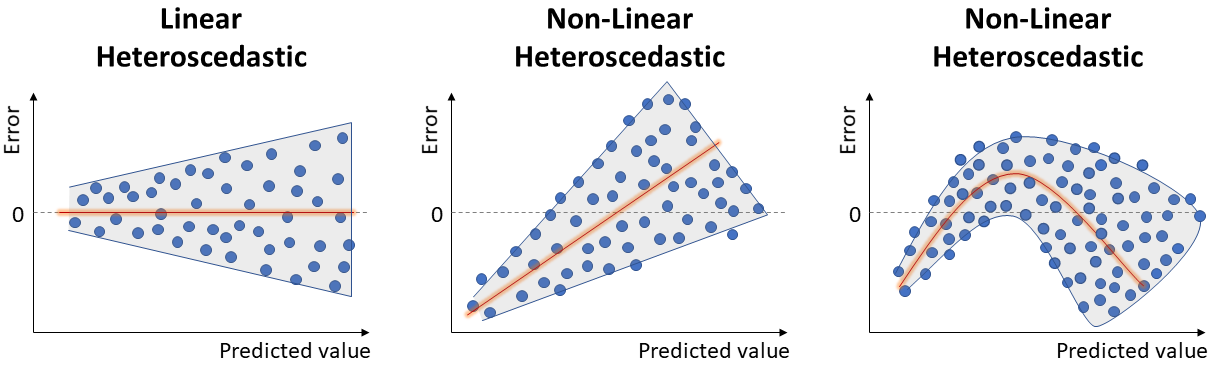

To address *heteroscedastic* models, it is typical to apply some transformation on the response, $y$ to mitigate the non-constant variance of errors:
+ **Natural Log transformation**: only for positive values, spread out small values and bring large values closer. Appropriate if the variance increases in proportion to the mean.

+ **Reciprocal transformation**: applied on non-zero variable, appropriate for very skewed data, approximating it to a normal distribution

+ **Square Root**: only for positive values, appropriate if variance changes proportionately to the square root of the mean.

+ **Higher Order**: appropriate if variance increases in proportion to the square or higher of the mean.

+ **[Box-Cox technique](https://www.statisticshowto.datasciencecentral.com/box-cox-transformation/)**: this technique allows to systematically test the best parameter $\lambda$ in the power transformation. Ultimately, it identifies the best type of transformation to be applied in order to approximate the variable to a normal distribution.

$$y(\lambda) = \begin{cases}
  \frac{y^{\lambda} - 1}{\lambda},\space \text{if $\lambda \neq 0$}\\
  ln(y), \space \text{if $\lambda = 0$}
\end{cases}$$

> **Hint**: when dealing with negative values, add a constant to the variable in order to transform it into positive values before using Box-Cox technique.

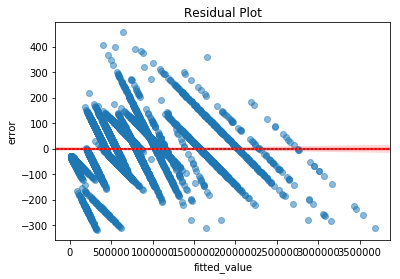

In [29]:
residual_plot(df, fitted_model)

Because the lack of linearity dominates the plot, we cannot use this **Residual Plot** to evaluate whether or not the error variances are equal. 

It would be necessary to fix the non-linearity problem before verifying the assumption of **homoscedasticity**. Since this falls outside the scope of this notebook, it will not be covered.